In [1]:
import scvelo as scv
import dynamo as dyn
import numpy as np
from anndata import AnnData
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset, get_worker_info

CHECKPOINT_PREFIX = "g2g"

import sys
sys.path.append('..')

method = ''
from utils.g2g_model_Fisher import *
from utils.utils import *
from utils.RKHS import *

In [2]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

2.4.0
11.8
True
1
0


In [3]:
data_path = 'data/'
data_name = 'DG_bin'

adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# set the parameters
[k_nei, K, L] = [10, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral_r']

In [4]:
#-------data preprocessing
adata=adata0.copy()
scv.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.pca(adata,n_comps=50)
scv.pp.moments(adata, n_pcs=50, n_neighbors=k_nei)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
cell_vpt = adata.obs['palantir_pseudotime']
Xs = adata.layers['Ms']#adata.X.A#
velo0 = np.array(adata.layers['velocity'])
velo_g = np.zeros(velo0.shape)
velo_g[:,adata.var['velocity_genes']] = velo0[:,adata.var['velocity_genes']]
velo_pca = adata.obsm['velocity_pca']

if norm=='standard':
    Xs_mean = np.mean(Xs,axis=0)
    Xs_std = np.std(Xs,axis=0)
    X = (Xs-Xs_mean)/Xs_std
    velo = velo_g/Xs_std
elif norm=='minmax':
    Xs_max = np.max(Xs,axis=0)
    Xs_min = np.min(Xs,axis=0)
    X = (Xs-Xs_min)/Xs_max
    velo = velo_g/Xs_max
else:
    X = Xs
#     velo = velo_g
    velo = velo_pca@adata.varm['PCs'].T

In [6]:
row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = adata.uns['neighbors']['indices'].flatten()
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

In [7]:
cell_nei = np.load(result_path+'cell_nei.npy')
nei_w = np.load(result_path+'nei_w.npy')

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return X_s

In [8]:
xsgn = -1
X_plt = xsgn*X_pca[:,0]
Y_plt = X_pca[:,1]
X_min = np.min(X_plt)
X_max = np.max(X_plt)
Y_min = np.min(Y_plt)
Y_max = np.max(Y_plt)
X_len = (X_max-X_min)/5
Y_len = (Y_max-Y_min)/5
wid = min(X_len,Y_len)/30
X_ori = X_min
Y_ori = Y_min

In [9]:
encoder = torch.load(result_path+'encoder.pt')

In [10]:
mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

In [11]:
#-------------transcription factors analysis
df = pd.read_csv('gene lists/mouse_TF_list.csv')
TF = df['Symbol'].values

for ti in range(len(TF)):
    TF[ti] = TF[ti].upper()

In [12]:
gene_list = np.array([x.upper() for x in adata.var.index.values])
tf_inds = np.where(np.in1d(gene_list,TF))[0]
non_tf_inds = np.where(~np.in1d(gene_list,TF))[0]
tf_gene = adata.var.index.values[tf_inds]
print(len(tf_inds))

45


In [13]:
#------use a simple neural network to study dmu/dt and dsigma/dt
pca_dim = 50
from torch.optim import SGD
reset_seeds(0)

model = nn.Sequential(
    nn.Linear(pca_dim, 128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,2*L),
)

# Define your loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.01, weight_decay=0.001)#, momentum=0.2

latent_z = np.hstack((mu_learned,sigma_learned))

x_in=torch.tensor(X_pca.astype(np.float32))
x_out=torch.tensor(latent_z.astype(np.float32))
# Train the model
for epoch in range(200):  # number of epochs
    # Forward pass
    output = model(x_in)
    loss = loss_fn(output,x_out) 
#     if epoch% 10 == 9:
#         print(epoch,loss)
    # Backward pass and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

pZ_pX = np.zeros([X.shape[0], L*2, X_pca.shape[1]])

# Compute the gradients
for i in range(X.shape[0]):
    x0=torch.tensor(X_pca[i,:],requires_grad=True)
    z=model(x0)
    for j in range(2*L):
        x0.grad = None       
        z[j].backward(retain_graph=True)
        pZ_pX[i,j,:] = x0.grad.detach()

In [14]:
g_pc = np.zeros([X.shape[0],pca_dim,pca_dim])
for i in range(X.shape[0]):
    g_pc[i] = pZ_pX[i].T @ Fisher_g[i] @ pZ_pX[i]

gene_gij = np.zeros([X.shape[0],X.shape[1]])
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        gene_gij[i,j] = adata.varm['PCs'][j]@g_pc[i]@adata.varm['PCs'][j]

gene_tf = gene_gij[:,tf_inds]

In [15]:
adata.layers['Fisher_info'] = gene_gij

In [16]:
tf_max = np.array([np.argmax(gene_tf[i]) for i in range(X.shape[0])])
gene_tf_max = np.array([gene_tf[i,int(tf_max[i])] for i in range(X.shape[0])])

In [17]:
ppt_ind = np.argsort(cell_vpt)
n_cells = Xs.shape[0]

In [18]:
tf_max_uni = np.unique(list(tf_max))
tf_max_num = np.zeros(tf_max_uni.shape[0])
for i in range(tf_max_uni.shape[0]):
    tf_max_num[i] = np.sum(tf_max==tf_max_uni[i])

tf_gene_max = tf_gene[tf_max_uni[tf_max_num>10]]
tf_inds_max = tf_inds[tf_max_uni[tf_max_num>10]]

In [19]:
fi_max = np.array([np.argmax(gene_gij[i]) for i in range(X.shape[0])])
gene_fi_max = np.array([gene_gij[i,int(fi_max[i])] for i in range(X.shape[0])])

fi_max_uni = np.unique(list(fi_max))
fi_max_num = np.zeros(fi_max_uni.shape[0])
for i in range(fi_max_uni.shape[0]):
    fi_max_num[i] = np.sum(fi_max==fi_max_uni[i])

fi_inds_max = fi_max_uni[np.argsort(fi_max_num)[-20:]]
fi_gene_max = gene_arr[fi_inds_max]

In [20]:
import seaborn as sns

palette1 = sns.color_palette('bright')
palette2 = sns.color_palette('pastel')
palette3 = sns.color_palette('muted')
c1 = tuple((np.array(palette1[0])+np.array(palette1[-1]))/2)
c2 = tuple((np.array(palette2[0])+np.array(palette2[-1]))/2)

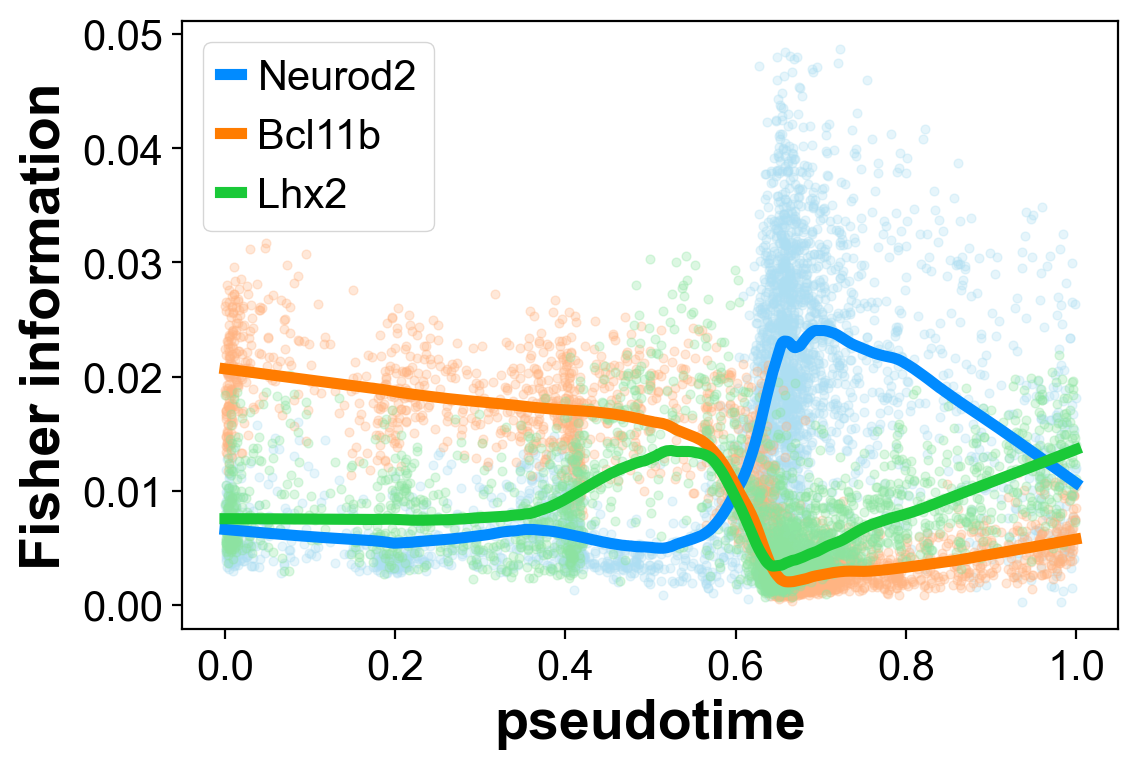

In [21]:
alpha = 0.3
frac = 0.2
ln = [0]*tf_inds_max.shape[0]
for i in range(tf_inds_max.shape[0]):
    mask1,x_ls1,y_ls1 = kde_lowess(cell_vpt,gene_gij[:,tf_inds_max[i]],frac=frac)
    if i==0:
        c_scatter = c2
        c_plot = c1
    else:
        c_scatter = palette2[i]
        c_plot = palette1[i]
    plt.scatter(cell_vpt[mask1],gene_gij[mask1,tf_inds_max[i]],s=10,alpha=alpha,c=c_scatter)
    ln[i] = plt.plot(x_ls1, y_ls1, linewidth=4,label=gene_arr[tf_inds_max[i]],c=c_plot)
plt.xlabel('pseudotime',fontsize=20,weight='bold')
plt.ylabel('Fisher information',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(handles=ln[0]+ln[1]+ln[2],fontsize=15)
plt.savefig(figure_path+'dg_tf_fi_max3.png',dpi=600,bbox_inches='tight')

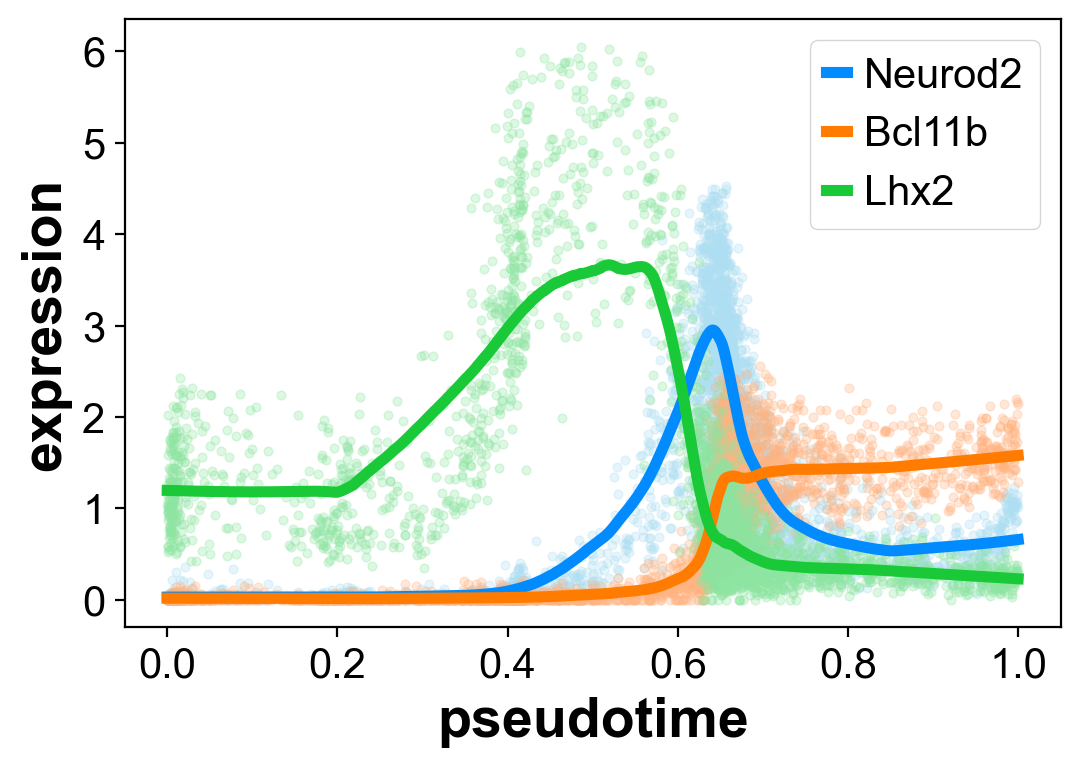

In [22]:
alpha = 0.3
frac = 0.2
ln = [0]*tf_inds_max.shape[0]
for i in range(tf_inds_max.shape[0]):
    mask1,x_ls1,y_ls1 = kde_lowess(cell_vpt,Xs[:,tf_inds_max[i]],frac=frac)
    if i==0:
        c_scatter = c2
        c_plot = c1
    else:
        c_scatter = palette2[i]
        c_plot = palette1[i]
    plt.scatter(cell_vpt[mask1],Xs[mask1,tf_inds_max[i]],s=10,alpha=alpha,c=c_scatter)
    ln[i] = plt.plot(x_ls1, y_ls1, linewidth=4,label=gene_arr[tf_inds_max[i]],c=c_plot)
plt.xlabel('pseudotime',fontsize=20,weight='bold')
plt.ylabel('expression',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(handles=ln[0]+ln[1]+ln[2],fontsize=15)
#plt.savefig(figure_path+'dg_tf_fi_max3.png',dpi=600,bbox_inches='tight')

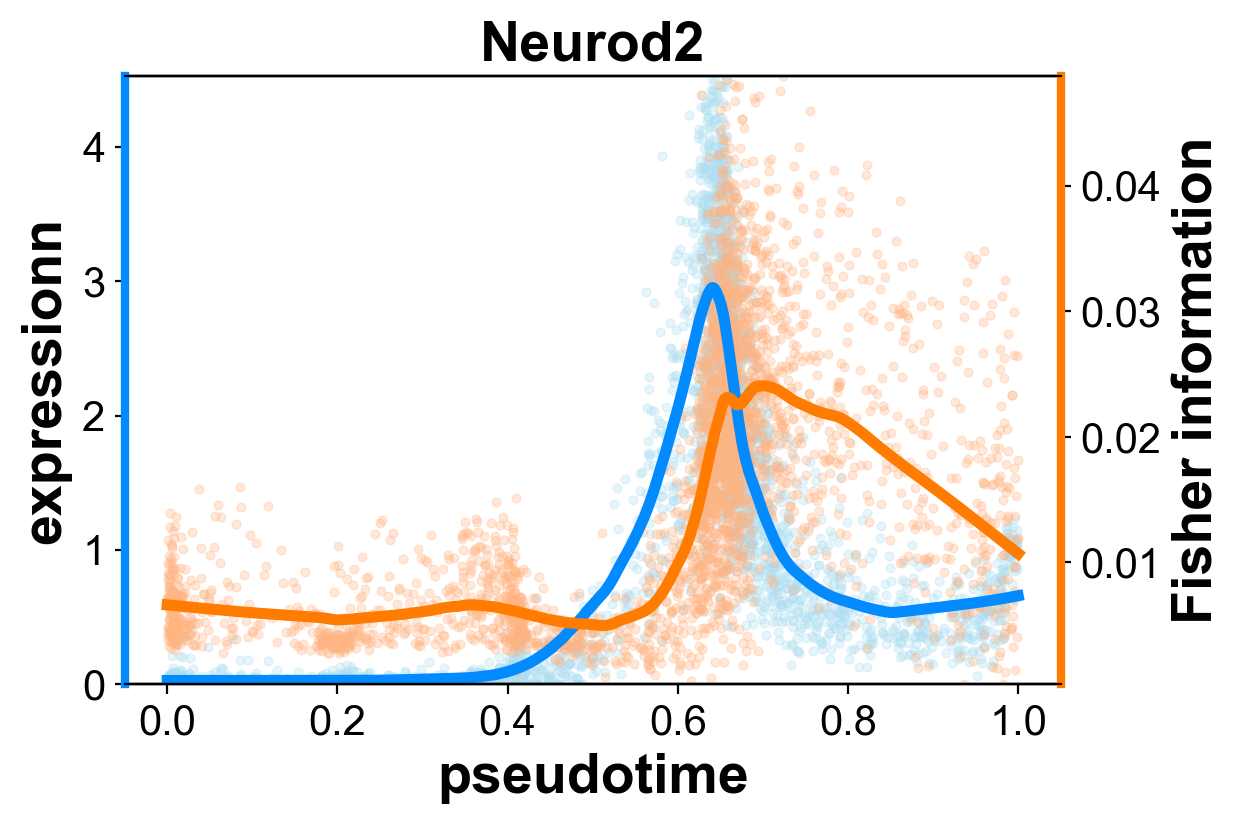

In [23]:
ng = 3
alpha = 0.3
frac = 0.2

# plt.figure(dpi=600,bbox_inches='tight')
mask1,x_ls1,y_ls1 = kde_lowess(cell_vpt,Xs[:,tf_inds[ng]],frac=frac)
plt.scatter(cell_vpt[mask1],Xs[mask1,tf_inds[ng]],s=10,c=c2,alpha=alpha)
plt.xlabel('pseudotime',fontsize=20,weight='bold')
plt.ylabel('expressionn',fontsize=20,weight='bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(min(Xs[mask1,tf_inds[ng]]),max(Xs[mask1,tf_inds[ng]]))

plt.twinx()
mask2,x_ls2,y_ls2 = kde_lowess(cell_vpt,gene_gij[:,tf_inds[ng]],frac=frac)
plt.scatter(cell_vpt[mask2],gene_gij[mask2,tf_inds[ng]],s=10,c=palette2[1],alpha=alpha)
plt.yticks([])
plt.ylim(min(gene_gij[mask2,tf_inds[ng]]),max(gene_gij[mask2,tf_inds[ng]]))

plt.twinx()
ln1 = plt.plot(x_ls1, y_ls1, linewidth=4,color=c1,label='Fisher information')
plt.yticks([])
plt.ylim(min(Xs[mask1,tf_inds[ng]]),max(Xs[mask1,tf_inds[ng]]))

plt.twinx()
ln2 = plt.plot(x_ls2, y_ls2, linewidth=4,color=palette1[1],label='expression')
plt.yticks(fontsize=15)
plt.ylabel('Fisher information',fontsize=20,weight='bold')
plt.ylim(min(gene_gij[mask2,tf_inds[ng]]),max(gene_gij[mask2,tf_inds[ng]]))

ax = plt.gca()
ax.spines['left'].set_color(c1)
ax.spines['right'].set_color(palette1[1])
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
#plt.legend(handles=ln1+ln2,fontsize=15)
plt.title(tf_gene[ng],fontsize=20,weight='bold')
#plt.savefig(figure_path+'6d.png',dpi=600,bbox_inches='tight')
plt.show()

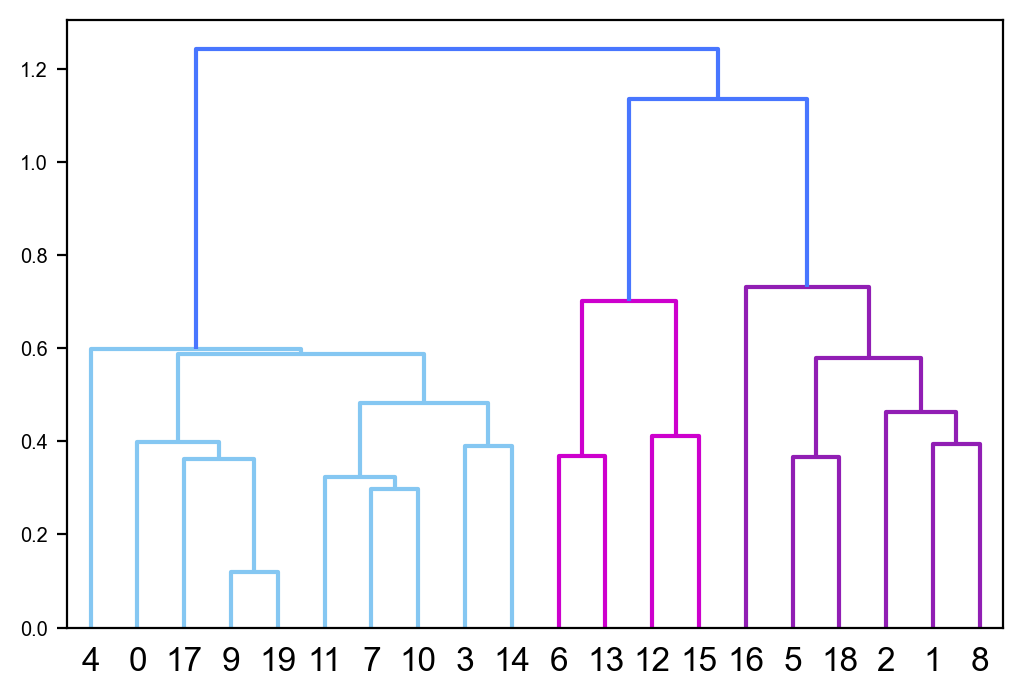

In [24]:
scaler = StandardScaler()#MinMaxScaler()#
X_tf = gene_gij[:,fi_inds_max]
X_tfs = scaler.fit_transform(X_tf)

X_corr = np.corrcoef(X_tf, rowvar=False)
Z = linkage((1-X_corr)[np.triu_indices(X_corr.shape[0],k=1)],method='weighted')#method='weighted')
dg = dendrogram(Z)

In [25]:
fi_inds_max_tf = fi_inds_max[dg['leaves']]
fi_gene_max_tf = gene_arr[fi_inds_max_tf]
gene_gij_tf = gene_gij[:,fi_inds_max_tf]

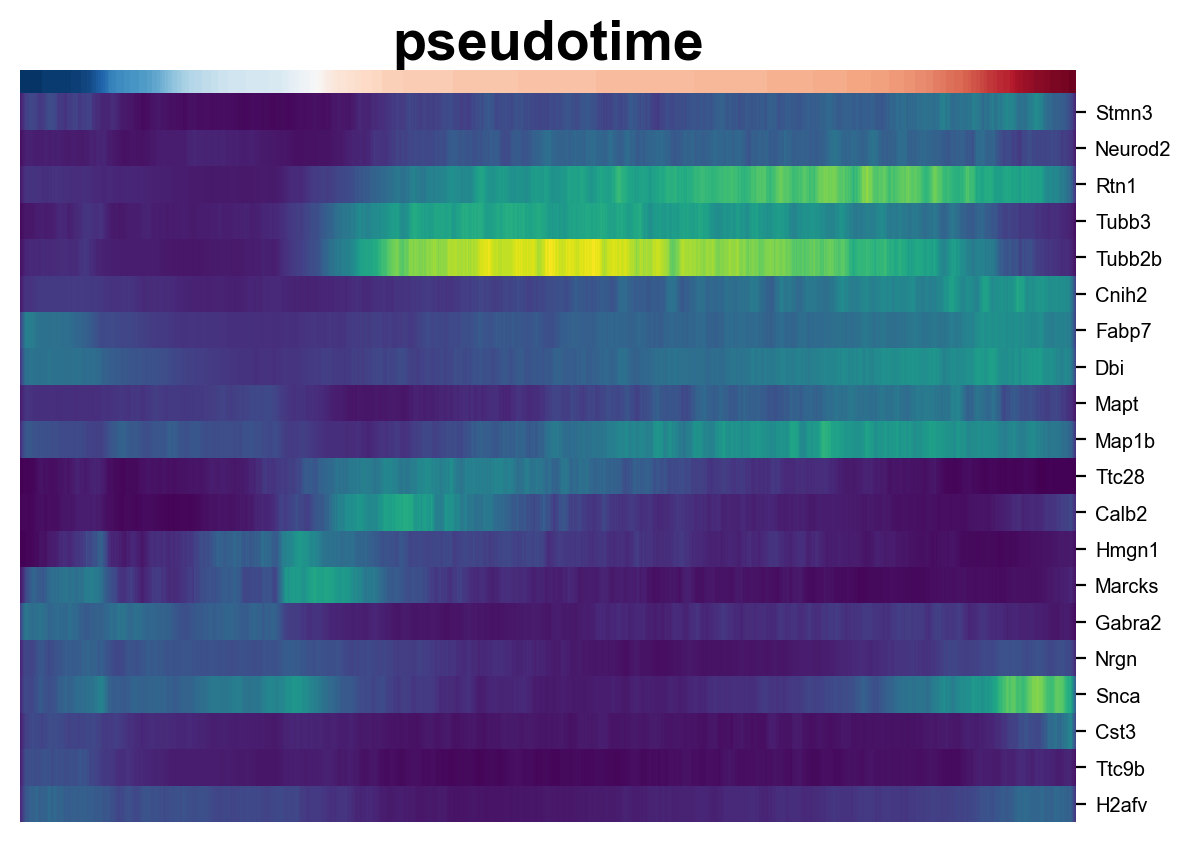

In [26]:
tkey = 'palantir_pseudotime'
n_convolve = 30

tlabels = np.arange(11)/10
tticks = np.zeros(tlabels.shape)
tkey_sorted = np.sort(adata.obs[tkey])
for i in range(len(tlabels)):
    tticks[i] = np.argmin(abs(tkey_sorted-tlabels[i]))

#adata.obs['cluster'] = np.array(adata.obs['Clusters'].astype('int'))
ax = scv.pl.heatmap(adata,
               var_names=fi_gene_max_tf,
               layer='Fisher_info',
               sort=False,
               tkey=tkey,
               n_convolve=n_convolve,
               palette=sns.color_palette("RdBu_r",n_colors=101),
               col_color=tkey,
               standard_scale=None,
               # row_colors=[crow_cor,crow_eg],
               #row_colors=crow_eg,
               figsize=(6,4),
               show=False
#                save=result_path+'heatmap_crc_X_vpt.png'
               )
# ax.ax_col_colors.xaxis.tick_top()
# ax.ax_col_colors.set_xticks(tticks,labels=tlabels,rotation=30)
ax.ax_col_colors.xaxis.set_label_position('top')
# ax.ax_col_colors.set_xlabel('information length',fontsize=15)  
ax.ax_col_colors.set_xlabel('pseudotime',fontsize=20,weight='bold')  
ax.figure.savefig(figure_path+'dg_max_fi.png',dpi=600,bbox_inches='tight')